# Problem Statement :

* Identify which questions asked on Quora are duplicates of questions that have already been asked.
* This could be useful to instantly provide answers to questions that have already been answered.
* We are tasked with predicting whether a pair of questions are duplicates or not.

# Target :

1. Exploratory Data Analysis
2. Machine Learning Models

In [63]:
!pip install distance
!pip install fuzzywuzzy

In [64]:
import numpy as np
# NumPy is a library for working with arrays and numerical operations

import pandas as pd
# Pandas is a data manipulation library, useful for working with structured data

import seaborn as sns
# Seaborn is a data visualization library based on matplotlib

import matplotlib.pyplot as plt
# Matplotlib is a plotting library for creating static, animated, and interactive visualizations

from subprocess import check_output
# The subprocess module allows you to spawn new processes and interact with their input/output/error pipes

%matplotlib inline
# This is a line magic for Jupyter Notebooks to display plots inline within the notebook

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
# Plotly is a library for creating interactive, web-based visualizations

import os
# The os module provides a way to interact with the operating system

import gc
# The gc module provides an interface to the cycle-detecting garbage collector

import re
# The re module provides regular expression matching operations

from nltk.corpus import stopwords
# NLTK (Natural Language Toolkit) is a library for working with human language data. stopwords is a corpus of stop words (common words to be filtered out)

import distance
# The distance module provides utilities for computing string distances

from nltk.stem import PorterStemmer
# PorterStemmer is a class for stemming words (removing affixes)

from bs4 import BeautifulSoup
# BeautifulSoup is a library for parsing HTML and XML documents

import warnings
warnings.filterwarnings("ignore")
# This line suppresses warning messages

from fuzzywuzzy import fuzz
# fuzzywuzzy is a library for string matching and fuzzy string comparison

from sklearn.manifold import TSNE
# TSNE is a technique for dimensionality reduction, useful for visualizing high-dimensional data

from wordcloud import WordCloud, STOPWORDS
# WordCloud is a library for generating word clouds from text data

from os import path
# The path module from os is used for working with file paths

from PIL import Image
# PIL (Python Imaging Library) is a library for opening, manipulating, and saving images

In [65]:
df = pd.read_csv("quora.csv")

print("Number of data points:",df.shape[0])

Number of data points: 404290


In [66]:
df.head()


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [67]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


Explanation of columns in our data set :

* id: Looks like a simple rowID
* qid{1, 2}: The unique ID of each question in the pair
* question{1, 2}: The actual textual contents of the questions.
* is_duplicate: The label that we are trying to predict - whether the two questions are duplicates of each other.

## ***Finding No. of Duplicate and Non-Duplicate Questions:***

--> Total number of question pairs for training : 404290

--> Question pairs are not Similar (is_duplicate = 0) :  63.08%

--> Question pairs are Similar (is_duplicate = 1) :  36.92%


Text(0.5, 1.0, 'Number of Duplicate and Non-duplicate Questions')

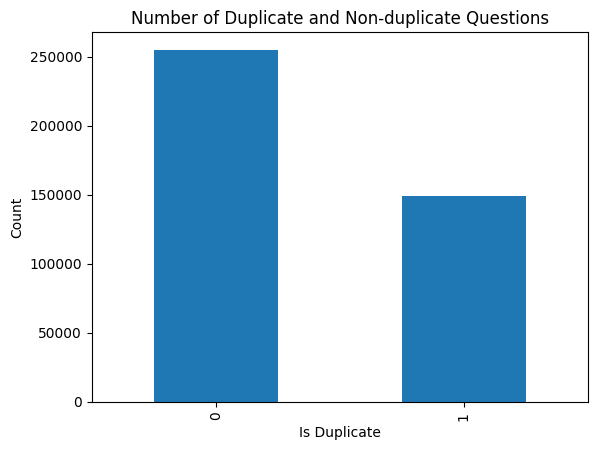

In [68]:
print('--> Total number of question pairs for training : {}'.format(len(df)))
print('\n--> Question pairs are not Similar (is_duplicate = 0) :  {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n--> Question pairs are Similar (is_duplicate = 1) :  {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

df.groupby("is_duplicate")['id'].count().plot.bar()
plt.xlabel('Is Duplicate')
plt.ylabel('Count')
plt.title('Number of Duplicate and Non-duplicate Questions')



## ***Finding No. of Unique Questions:***

Total number of Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



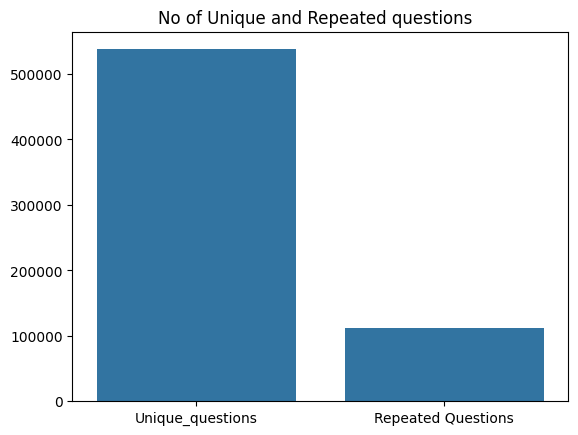

In [69]:
#Create a Series by combining qid1 and qid2 columns from the dataframe
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())


#Get the number of unique questions by finding unique values in qids
unique_qs = len(np.unique(qids))


#Count the number of questions that appear more than once
qs_morethan_onetime = np.sum(qids.value_counts() > 1)


#Print the total number of unique questions
print ('Total number of Unique Questions are: {}\n'.format(unique_qs))


#Print the number and percentage of unique questions that appear more than once
print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime, qs_morethan_onetime/unique_qs*100))


#Print the maximum number of times a single question is repeated
print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts())))


#Get the value_counts of qids as a Series
q_vals = qids.value_counts()


#Convert the value_counts Series to a NumPy array
q_vals = q_vals.values


x = ["Unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure()
plt.title ("No of Unique and Repeated questions  ")
sns.barplot(x=x,y=y)
plt.show()


## **Let's recheck if there are any duplicates left ?**




In [70]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("--> Number of duplicate questions :",(pair_duplicates).shape[0] - df.shape[0])

--> Number of duplicate questions : 0


## **Checking and handling NULL values**


In [84]:
# Checking for rows with null values
nan_rows = df[df.isnull().any(axis=1)]

if nan_rows.empty:
    print("No rows with null values found.")
else:
    print("Rows with null values:")
    print(nan_rows)

# Filling null values with empty strings
df.fillna('', inplace=True)

# Checking again for any rows with null values after filling
nan_rows_after_fill = df[df.isnull().any(axis=1)]

if nan_rows_after_fill.empty:
    print("\n All null values have been successfully filled with empty strings.")
else:
    print("\n Some null values could not be filled. Remaining rows with null values:")
    print(nan_rows_after_fill)

No rows with null values found.

 All null values have been successfully filled with empty strings.


## **Feature Extraction**


In [72]:
# Check if the file exists, if not, perform feature engineering
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1') # Read the CSV file
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') # Count frequency of qid1
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count') # Count frequency of qid2
    df['q1len'] = df['question1'].str.len() # Calculate length of question1
    df['q2len'] = df['question2'].str.len() # Calculate length of question2
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" "))) # Count number of words in question1
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" "))) # Count number of words in question2

    # Function to calculate normalized word common between question1 and question2
    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1) # Apply the function to calculate word_Common

    # Function to calculate normalized total words in question1 and question2
    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1) # Apply the function to calculate word_Total

    # Function to calculate normalized word share between question1 and question2
    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1) # Apply the function to calculate word_share

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2'] # Calculate sum of frequencies
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2']) # Calculate absolute difference of frequencies

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False) # Save the dataframe to a CSV file

df.head() # Display the first few rows of the dataframe

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


  
  * **Some questions having single words only !!**


In [73]:
print ("\n Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("\n Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("\n Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("\n Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])


 Minimum length of the questions in question1 :  1

 Minimum length of the questions in question2 :  1

 Number of Questions with minimum length [question1] : 67

 Number of Questions with minimum length [question2] : 24


#  **Feature -- Words Share**

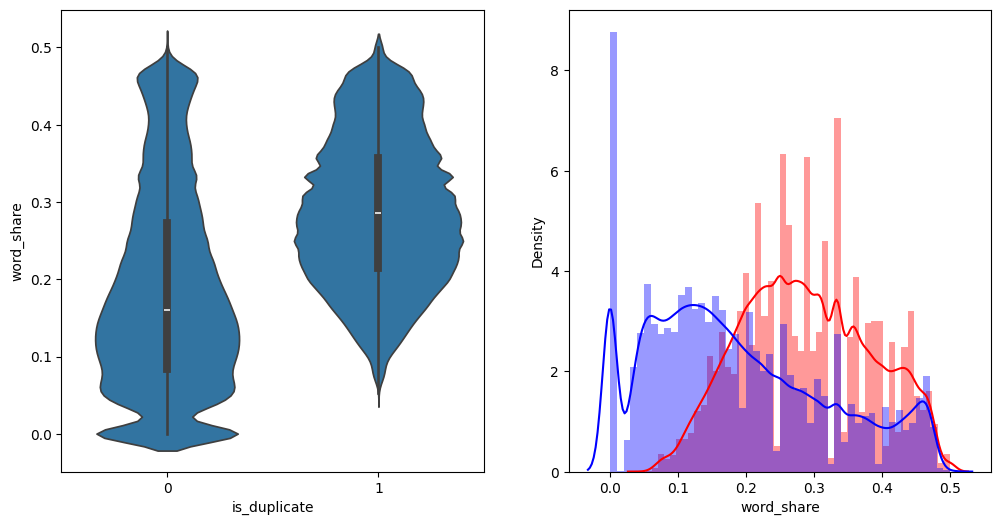

In [74]:
plt.figure(figsize=(12, 6)) # Create a new figure

plt.subplot(1,2,1) # Create the first subplot (1 row, 2 columns, first plot)

sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:]) # Plot a violin plot with 'is_duplicate' on x-axis and 'word_share' on y-axis

plt.subplot(1,2,2) # Create the second subplot (1 row, 2 columns, second plot)

sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red') # Plot distribution of 'word_share' for duplicate questions (label=1) in red

sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' ) # Plot distribution of 'word_share' for non-duplicate questions (label=0) in blue

plt.show() # Display the figure

# *Insights from figures above* :

*   The distributions of 'word_share' for duplicate and non-duplicate question pairs have some overlap on the higher end of the range.

*   There are a significant number of question pairs, both duplicate and non-duplicate, that have a high 'word_share' value, indicating a large proportion of shared words between the questions.

* However, on average, the 'word_share' and the count of common words tend to be higher for duplicate question pairs compared to non-duplicate pairs.



#  **Feature -- Common Words**

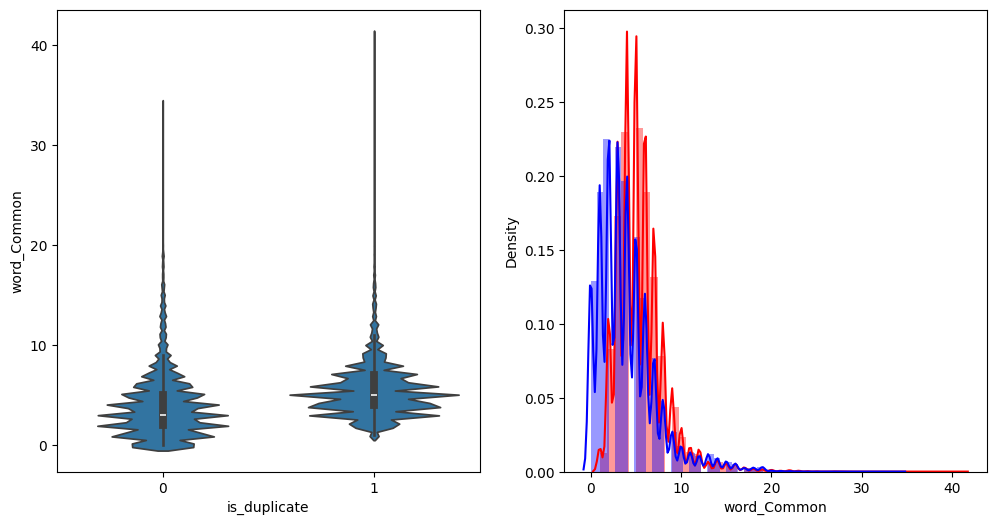

In [75]:
plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()


# *Insights from figures above :*
*   The 'word_Common' feature, which represents the number of common unique words between two questions, has highly overlapping distributions for similar (duplicate) and non-similar (non-duplicate) question pairs.

*   This overlap in distributions suggests that the 'word_Common' feature alone may not be very effective in distinguishing between duplicate and non-duplicate question pairs.

* In contrast, the 'word_share' feature, which normalizes the common word count by the total word count, provides better separability between duplicate and non-duplicate questions compared to 'word_Common'.



# **Pre-processing of Text :**


*  Removing html tags
*  Removing Punctuations
*  Performing stemming
*  Removing Stopwords
*  Expanding contractions etc.
  


In [96]:
import nltk   # Import the Natural Language Toolkit (NLTK) library

nltk.download('stopwords')   # Download the stopwords corpus from NLTK

from wordcloud import WordCloud


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [100]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001

STOP_WORDS = stopwords.words("english") #Load English stop words from NLTK

def preprocess(x):
    x = str(x).lower()  # Convert input to lowercase string

    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'") \
    .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
    .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
    .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
    .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
    .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
    .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)  # Replace numerical values with abbreviations (e.g., 1000000 -> 1m)
    x = re.sub(r"([0-9]+)000", r"\1k", x)


    porter = PorterStemmer() # Initialize PorterStemmer for stemming
    pattern = re.compile('\W')  # Compile regex pattern to match non-word characters


    if type(x) == type(''):  # Remove non-word characters and stem the remaining words
        x = re.sub(pattern, ' ', x)   # Replace non-word characters with spaces


    if type(x) == type(''):
        x = porter.stem(x)  # Stem the remaining words
        example1 = BeautifulSoup(x)  # Create BeautifulSoup object
        x = example1.get_text()  # Extract text from BeautifulSoup object

    return x  # Return the preprocessed text


# **Making Word Cloud for Duplicate words**

Word Cloud for Duplicate Question Pairs


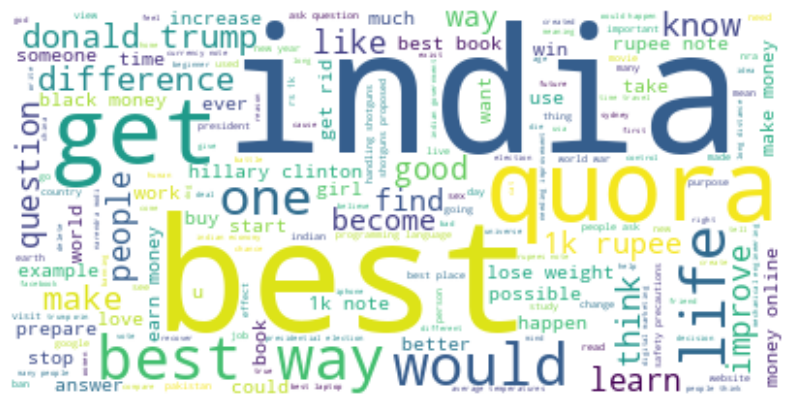

In [99]:


# Function to generate Word Cloud for duplicate question pairs
def generate_word_cloud(df):
    # Filter the dataframe for duplicate question pairs
    duplicate_pairs = df[df['is_duplicate'] == 1]

    # Concatenate the preprocessed question1 and question2 for duplicate pairs
    textp_w = ' '.join(duplicate_pairs['question1'].apply(preprocess) + ' ' + duplicate_pairs['question2'].apply(preprocess))

    # Create and generate the Word Cloud
    wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=STOP_WORDS)
    wc.generate(textp_w)
    print("Word Cloud for Duplicate Question Pairs")
    plt.figure(figsize=(10, 8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()


# Call the function with your dataframe
generate_word_cloud(df)